## Import and dataloaders

Before starting this tutorial, let's  import and define our dataloaders for CIFAR10.

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [2]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.data = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  # Returns (image, label) tuple

def get_dataloader(batch_size=4, num_workers=0, root='./data'):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = CIFAR10Dataset(root=root, train=True, transform=transform)
    test_dataset = CIFAR10Dataset(root=root, train=False, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader

# Get dataloaders
train_dataloader, test_dataloader = get_dataloader(batch_size=16, num_workers=0)

# Define class names
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 16

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000167869D5F30>, <torch.utils.data.dataloader.DataLoader object at 0x00000167869D6AD0>)
Length of train dataloader: 3125 batches of 16
Length of test dataloader: 625 batches of 16


## Batch Normalization and Dropout

Discover how batch normalization and dropout improve a model's accuracy.

We will be covering:

- Batch Normalization

- Notations

- Advantages and disadvantages of using batch normalization

- Dropout

### Batch Normalization

If you open any introductory machine learning textbook, you will find the idea of **input scaling**. It is undesirable to train a model with **gradient descent** with non-normalized input features.

Let’s start with an intuitive example to understand why we want normalization inside any model.

Suppose you have an input feature $x1$ in the range [0,10000] and another feature $x2$ in the range [0,1]. Any linear combination would ignore $x2$ such that $x1*w1 + x2*w2 \approx x1$, since our weights are initialized in a very tiny range like [-1,1].

We encounter the same issues inside the layers of deep neural networks. In this lesson, we will propagate this idea inside the NN.

> If we think out of the box, any intermediate layer is conceptually the same as the input layer; it accepts features and transforms them

### Notations

Throughout this lesson, $N$ will be the batch size, $H$ will refer to the height, $W$ to the width, and $C$ to the feature channels. The greek letter $\mu()$ refers to mean and the greek letter $\sigma()$ refers to standard deviation.

The batch features are denoted by $x$ with a shape of $[N, C, H, W]$.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig22.PNG)

We will visualize the 4D activation maps x by **merging the spatial dimensions**. Now, we have a 3D shape that looks like this:

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig23.PNG)

The most dominant solution is batch normalization. Let’s see how it works.

> Batch Normalization (BN) normalizes the mean and standard deviation **for each individual feature channel/map**.

First of all, the mean and standard deviation are first-order statistics, and thus they relate to the **global characteristics** (such as the image style).

In this way, we somehow blend the global characteristics. Such a strategy is effective when we want our representation to share these characteristics. This is the reason that we widely utilize BN in downstream tasks (i.e., image classification).

From a mathematical point of view, **you can think of it as bringing the features of the image in the same range**.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig24.PNG)

Specifically, we demand from our features to follow a Gaussian distribution with zero mean and unit variance. Mathematically, this can be expressed as:

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig25.PNG)

The index $c$ denotes the per-channel (feature map) mean.

Let’s see this operation visually:

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig26.PNG)

Notably, the spatial dimensions as well as the image batch are averaged. This way, **we concentrate our features in a compact Gaussian-like space**, which is usually beneficial.

In fact, $\gamma$ and $\beta$ correspond to the trainable parameters that result in the linear/affine transformation, which is different for all channels.

Specifically $\gamma$ and $\beta$ are vectors with the channel dimensionality.

### Advantages and disadvantages of using batch normalization

The following are some **advantages** of BN:

- BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.

- For every input mini-batch, we calculate different statistics. This introduces some sort of regularization. Regularization refers to any form of technique/constraint that restricts the complexity of a deep neural network during training.

- BN also has a beneficial effect on the gradient flow through the network. It reduces the dependence of gradients on the scale of the parameters or of their initial values. This allows us to use much higher learning rates.

- In theory, BN makes it possible to use saturating nonlinearities by preventing the network from getting stuck, but we just use nn.ReLU().

- BN makes the gradients more predictive.

BN has the following **disadvantages**:

- Batch normalization may cause inaccurate estimation of batch statistics when we have a small batch size. This increases the model error. In tasks such as image segmentation, the batch size is usually too small. BN needs a sufficiently large batch size.

Let’s now implement batch normalization from scratch for images of size $[N, C, H, W]$. All you have to do is transform the above equations to Pytorch. The tricky part is to correctly figure out the sizes of each tensor.

In [4]:
import torch

# Gamma and beta are provided as 1d tensors.
# X is the data in a mini-batch

def batchnorm(X, gamma, beta):

    # extract the dimensions
    N, C, H, W = list(X.size())
    # mini-batch mean
    mean = torch.mean(X, dim=(0, 2, 3))
    # mini-batch variance
    variance = torch.mean((X - mean.reshape((1, C, 1, 1))) ** 2, dim=(0, 2, 3))
    # normalize
    X_hat = (X - mean.reshape((1, C, 1, 1))) * 1.0 / torch.sqrt(variance.reshape((1, C, 1, 1)) )
    # scale and shift
    out = gamma.reshape((1, C, 1, 1)) * X_hat + beta.reshape((1, C, 1, 1))

    return out

In [5]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

BN_layer = nn.BatchNorm2d(3)
output_BN = BN_layer(images)

In [6]:
print(images)

tensor([[[[ 0.1765,  0.3098,  0.3569,  ...,  0.2392,  0.2157,  0.2549],
          [ 0.2078,  0.2863,  0.3255,  ...,  0.1765,  0.1608,  0.2078],
          [ 0.2157,  0.2235,  0.2941,  ...,  0.2471,  0.2784,  0.3490],
          ...,
          [ 0.2549,  0.2000,  0.1922,  ...,  0.3176,  0.3569,  0.3255],
          [ 0.2000,  0.1765,  0.1922,  ...,  0.2706,  0.3412,  0.3804],
          [ 0.1843,  0.1608,  0.1294,  ...,  0.3098,  0.3647,  0.3569]],

         [[ 0.0745,  0.2078,  0.2549,  ...,  0.1686,  0.1529,  0.1922],
          [ 0.0980,  0.1843,  0.2235,  ...,  0.1059,  0.0980,  0.1451],
          [ 0.1137,  0.1216,  0.1922,  ...,  0.1843,  0.2157,  0.2863],
          ...,
          [ 0.1922,  0.1373,  0.1294,  ...,  0.2392,  0.2784,  0.2471],
          [ 0.1373,  0.1137,  0.1294,  ...,  0.1922,  0.2627,  0.3020],
          [ 0.1216,  0.0980,  0.0667,  ...,  0.2314,  0.2863,  0.2784]],

         [[ 0.0275,  0.1608,  0.2078,  ...,  0.1608,  0.1373,  0.1765],
          [ 0.0510,  0.1373,  

In [7]:
print(output_BN)

tensor([[[[ 3.8694e-01,  6.5245e-01,  7.4616e-01,  ...,  5.1189e-01,
            4.6503e-01,  5.4312e-01],
          [ 4.4941e-01,  6.0560e-01,  6.8369e-01,  ...,  3.8694e-01,
            3.5570e-01,  4.4941e-01],
          [ 4.6503e-01,  4.8065e-01,  6.2121e-01,  ...,  5.2750e-01,
            5.8998e-01,  7.3054e-01],
          ...,
          [ 5.4312e-01,  4.3380e-01,  4.1818e-01,  ...,  6.6807e-01,
            7.4616e-01,  6.8369e-01],
          [ 4.3380e-01,  3.8694e-01,  4.1818e-01,  ...,  5.7436e-01,
            7.1492e-01,  7.9301e-01],
          [ 4.0256e-01,  3.5570e-01,  2.9323e-01,  ...,  6.5245e-01,
            7.6178e-01,  7.4616e-01]],

         [[ 3.2314e-01,  6.0498e-01,  7.0445e-01,  ...,  5.2209e-01,
            4.8893e-01,  5.7182e-01],
          [ 3.7288e-01,  5.5524e-01,  6.3814e-01,  ...,  3.8946e-01,
            3.7288e-01,  4.7235e-01],
          [ 4.0604e-01,  4.2261e-01,  5.7182e-01,  ...,  5.5524e-01,
            6.2156e-01,  7.7077e-01],
          ...,
     

### Dropout

Another technique to train deep learning models is dropout.

Conceptually, dropout approximates training a large number of neural networks with different architectures in parallel.

> In practice, during training, some number of layer outputs are randomly ignored (dropped out) with probability $p$.

Thus, the same layer will alter its connectivity and will search for alternative paths to convey the information in the next layer. As a result, each update to a layer during training is performed with a different “view” of the configured layer.

“Dropping” values means temporarily removing them from the network for the current forward pass along with all its incoming and outgoing connections.

Dropout has the effect of making the training process noisy. The choice of the probability $p$ depends on the architecture.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/fig27.PNG)
This conceptualization suggests that perhaps dropout breaks-up situations where network layers co-adapt to correct mistakes from prior layers, in turn making the model more robust.

The neural network will adapt in a way that prevents overfitting, which refers to poor generalization to unseen data.

Dropout increases the sparsity of the network and in general encourages sparse representations!

You can find an example in the code below .

Notice that each value will be zeroed with a probability of p=0.5. Nonetheless, that doesn’t imply that the output will be 50% zeroed-out every time.

In [ ]:
import torch
import torch.nn as nn

inp = torch.rand(1,8) 
dropout_layer = nn.Dropout(0.5)
out1 = dropout_layer(inp)
out2 = dropout_layer(inp)
print(inp)
print(out1)
print(out2)

tensor([[0.6257, 0.9145, 0.6141, 0.4462, 0.6239, 0.4524, 0.5738, 0.4249]])
tensor([[0.0000, 1.8291, 1.2281, 0.8925, 0.0000, 0.0000, 0.0000, 0.8498]])
tensor([[1.2514, 0.0000, 1.2281, 0.8925, 1.2477, 0.0000, 1.1475, 0.0000]])


### Training with batchnorm

Now, it's the time to apply batchnorm and dropout! Let's copy and paste the code for training a CNN in our previous notebook.

Here, try to incorporate batchnorm as a layer in this vanilla CNN.

Note that in pytorch, batchnorm can be implemented using `nn.BatchNorm2d(num_features)` for 2D input and `nn.BatchNorm2d(num_features)` for 1D input.

### Training with dropout

Adding dropout to your PyTorch models is very straightforward with the `torch.nn.Dropout` class, which takes in the dropout rate – the probability of a neuron being deactivated – as a parameter.

Go back to the CNN class and try to incorporate dropout as an additional layer in the fully connected layer.

In [9]:
#1. DEFINE THE CNN WITH BATCHNORM
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(6) # defining our batchnorm1 layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batchnorm2 = nn.BatchNorm2d(16) # defining our batchnorm2 layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        # INCLUDE BATCHNORM IN THE FORWARD METHOD #
        x = self.batchnorm1(x)
        x = self.pool(self.relu(self.conv2(x)))
        # INCLUDE BATCHNORM IN THE FORWARD METHOD #
        x = self.batchnorm2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
model = CNN() # need to instantiate the network to be used in instance method

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)

In [11]:
import time
from tqdm.auto import tqdm

# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset)

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset)

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        # Use tqdm.write() instead of print() to avoid extra blank lines
        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history

c:\IIUM\AI Note IIUM\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
num_epochs =10
trained_model, history = train_and_validate(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs)

Training Progress:  10%|█         | 1/10 [00:49<07:24, 49.37s/it]

Epoch 1/10: Train loss: 1.6419, Train accuracy: 0.4042, Val loss: 1.3480, Val accuracy: 0.5109, Time: 49.37s


Training Progress:  20%|██        | 2/10 [01:38<06:34, 49.30s/it]

Epoch 2/10: Train loss: 1.2856, Train accuracy: 0.5387, Val loss: 1.2159, Val accuracy: 0.5597, Time: 49.25s


Training Progress:  30%|███       | 3/10 [02:28<05:45, 49.42s/it]

Epoch 3/10: Train loss: 1.1529, Train accuracy: 0.5892, Val loss: 1.1280, Val accuracy: 0.5969, Time: 49.55s


Training Progress:  40%|████      | 4/10 [03:15<04:52, 48.74s/it]

Epoch 4/10: Train loss: 1.0627, Train accuracy: 0.6227, Val loss: 1.0609, Val accuracy: 0.6276, Time: 47.71s


Training Progress:  50%|█████     | 5/10 [04:03<04:01, 48.32s/it]

Epoch 5/10: Train loss: 0.9986, Train accuracy: 0.6455, Val loss: 1.0270, Val accuracy: 0.6368, Time: 47.57s


Training Progress:  60%|██████    | 6/10 [04:52<03:14, 48.66s/it]

Epoch 6/10: Train loss: 0.9458, Train accuracy: 0.6654, Val loss: 1.0165, Val accuracy: 0.6468, Time: 49.31s


Training Progress:  70%|███████   | 7/10 [05:41<02:25, 48.59s/it]

Epoch 7/10: Train loss: 0.8987, Train accuracy: 0.6845, Val loss: 0.9815, Val accuracy: 0.6572, Time: 48.43s


Training Progress:  80%|████████  | 8/10 [06:29<01:37, 48.62s/it]

Epoch 8/10: Train loss: 0.8616, Train accuracy: 0.6969, Val loss: 0.9918, Val accuracy: 0.6539, Time: 48.70s


Training Progress:  80%|████████  | 8/10 [06:45<01:41, 50.67s/it]


KeyboardInterrupt: 

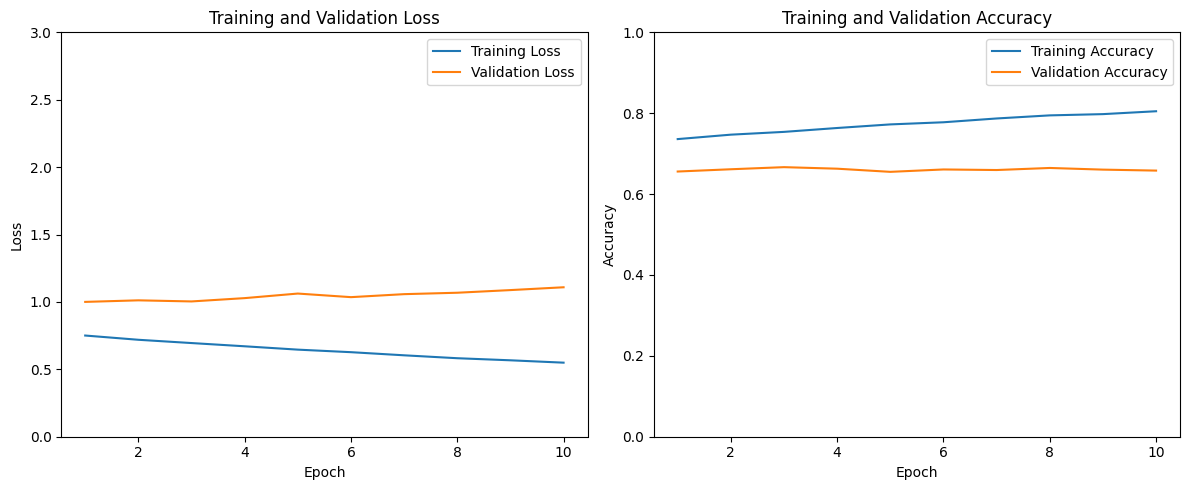

In [18]:
# Extracting data for plotting
train_losses = history['train_loss']
train_accuracies = history['train_accuracy']
val_losses = history['val_loss']
val_accuracies = history['val_accuracy']
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()